No lps data and pic data, need to understand what is the problem
```python

## Imports

In [1]:
import numpy as np
import scanpy as sc
import pandas as pd
import os
import bbknn
from pathlib import Path

## Single cell settings

In [2]:
sc.settings.verbosity = 4
sc.settings.set_figure_params(80)
sc.settings._file_format_figs = 'pdf'
sc.settings.savefigs = False
use_first_n_samples = 0
full_sparse = False

C:\Users\TzachiHNB2\AppData\Local\Temp\ipykernel_19492\3661074169.py:2: FutureWarning: The specified parameters ('scanpy',) are no longer positional. Please specify them like `scanpy=80`
  sc.settings.set_figure_params(80)


## Basic QC workflow

In [3]:
adatas = []

data_names = ['control_lps','control_pic']
main_path = '/Code/data/single_cell/animals/chicken/ca2/old_genome/control'
paths = ['\\control_lps','\\control_pic']    #...etc - Folders with matrix, features and barcodes gz files.
for path in paths:
    adata = sc.read_10x_mtx(main_path + path, var_names='gene_symbols', cache=False)    # use gene symbols for the variable names (variables-axis index)
    sc.logging.print_memory_usage()
    print(adata.shape)
    adatas.append(adata)

    reading \Code\data\single_cell\animals\chicken\ca2\old_genome\control\control_lps\matrix.mtx.gz
--> This might be very slow. Consider passing `cache=True`, which enables much faster reading from a cache file.
Memory usage: current 0.27 GB, difference +0.27 GB
(257, 24356)
    reading \Code\data\single_cell\animals\chicken\ca2\old_genome\control\control_pic\matrix.mtx.gz
--> This might be very slow. Consider passing `cache=True`, which enables much faster reading from a cache file.
Memory usage: current 0.33 GB, difference +0.06 GB
(3297, 24356)


In [4]:
adata_control = adatas[0].concatenate(adatas[1], batch_categories = data_names, batch_key='treatment')

c:\Python\Python310\lib\site-packages\anndata\_core\anndata.py:1763: FutureWarning: The AnnData.concatenate method is deprecated in favour of the anndata.concat function. Please use anndata.concat instead.

See the tutorial for concat at: https://anndata.readthedocs.io/en/latest/concatenation.html
  warnings.warn(


In [5]:
adata_control.obs['treatment'] = 'control'
adata_control.obs

,treatment
AAAGGTACATAGATGA-1-control_lps,control
AAAGGTAGTAGCTTGT-1-control_lps,control
AACACACGTATGTCTG-1-control_lps,control
AACAGGGCAGAGGACT-1-control_lps,control
AACCCAAAGATAACAC-1-control_lps,control
...,...
TTTGGTTTCACCTGTC-1-control_pic,control
TTTGGTTTCGCTGACG-1-control_pic,control
TTTGGTTTCTGCTTAT-1-control_pic,control
TTTGTTGCAGAGATGC-1-control_pic,control


In [6]:
adata_control.obs.index = [x.split('-control')[0] for x in adata_control.obs.index]
adata_control.obs.index

Index(['AAAGGTACATAGATGA-1', 'AAAGGTAGTAGCTTGT-1', 'AACACACGTATGTCTG-1',
       'AACAGGGCAGAGGACT-1', 'AACCCAAAGATAACAC-1', 'AACCTTTGTTGACTAC-1',
       'AACGTCACAACAGTGG-1', 'AACGTCATCTTAGCAG-1', 'AACTTCTCACATGACT-1',
       'AAGACAACAGGGATAC-1',
       ...
       'TTTGATCGTCGTATGT-1', 'TTTGGAGCAAATCGGG-1', 'TTTGGAGCACCTCGTT-1',
       'TTTGGAGTCTTTCTAG-1', 'TTTGGTTTCAAATAGG-1', 'TTTGGTTTCACCTGTC-1',
       'TTTGGTTTCGCTGACG-1', 'TTTGGTTTCTGCTTAT-1', 'TTTGTTGCAGAGATGC-1',
       'TTTGTTGGTGTTATCG-1'],
      dtype='object', length=3554)

In [7]:
adata_control

AnnData object with n_obs × n_vars = 3554 × 24356
    obs: 'treatment'
    var: 'gene_ids', 'feature_types'

In [8]:
adatas = [adata_control]
adata_control.obs_names_make_unique()

In [9]:
data_names = ['lps','pic']
main_path = '/Code/data/single_cell/animals/chicken/ca2/old_genome/'
paths = ['\\lps','\\pic']
for path in paths:
    adata = sc.read_10x_mtx(main_path + path, var_names='gene_symbols', cache=False)
    sc.logging.print_memory_usage()
    print(adata.shape)
    adatas.append(adata)

    reading \Code\data\single_cell\animals\chicken\ca2\old_genome\lps\matrix.mtx.gz
--> This might be very slow. Consider passing `cache=True`, which enables much faster reading from a cache file.
Memory usage: current 0.33 GB, difference +0.00 GB
(349, 24356)
    reading \Code\data\single_cell\animals\chicken\ca2\old_genome\pic\matrix.mtx.gz
--> This might be very slow. Consider passing `cache=True`, which enables much faster reading from a cache file.
Memory usage: current 0.35 GB, difference +0.02 GB
(2526, 24356)


In [10]:
adatas

[AnnData object with n_obs × n_vars = 3554 × 24356
     obs: 'treatment'
     var: 'gene_ids', 'feature_types',
 AnnData object with n_obs × n_vars = 349 × 24356
     var: 'gene_ids', 'feature_types',
 AnnData object with n_obs × n_vars = 2526 × 24356
     var: 'gene_ids', 'feature_types']

In [12]:
adata_control.obs

,treatment
AAAGGTACATAGATGA-1,control
AAAGGTAGTAGCTTGT-1,control
AACACACGTATGTCTG-1,control
AACAGGGCAGAGGACT-1,control
AACCCAAAGATAACAC-1,control
...,...
TTTGGTTTCACCTGTC-1,control
TTTGGTTTCGCTGACG-1,control
TTTGGTTTCTGCTTAT-1,control
TTTGTTGCAGAGATGC-1,control


In [13]:
adata_all_treatments = adata_control.concatenate([adatas[1], adatas[2]], batch_categories = ['control', 'lps', 'pic'])
adata_all_treatments

c:\Python\Python310\lib\site-packages\anndata\_core\anndata.py:1763: FutureWarning: The AnnData.concatenate method is deprecated in favour of the anndata.concat function. Please use anndata.concat instead.

See the tutorial for concat at: https://anndata.readthedocs.io/en/latest/concatenation.html
  warnings.warn(


AnnData object with n_obs × n_vars = 6429 × 24356
    obs: 'treatment', 'batch'
    var: 'gene_ids', 'feature_types'

In [14]:
adata_all_treatments.obs['treatment'] = adata_all_treatments.obs['treatment'].map({'control': 'control','lps': 'lps', 'pic': 'pic'})

In [17]:
adata_all_treatments.obs

,treatment,batch
AAAGGTACATAGATGA-1-control,control,control
AAAGGTAGTAGCTTGT-1-control,control,control
AACACACGTATGTCTG-1-control,control,control
AACAGGGCAGAGGACT-1-control,control,control
AACCCAAAGATAACAC-1-control,control,control
...,...,...
TTTGGAGTCTACCCAC-1-pic,NaN,pic
TTTGGTTAGGTTAAAC-1-pic,NaN,pic
TTTGGTTAGGTTTACC-1-pic,NaN,pic
TTTGGTTCAACGTAAA-1-pic,NaN,pic


In [18]:
adata_all_treatments.var

,gene_ids,feature_types
ENSGALG00000054818,ENSGALG00000054818,Gene Expression
ENSGALG00000053455,ENSGALG00000053455,Gene Expression
ENSGALG00000045540,ENSGALG00000045540,Gene Expression
ENSGALG00000051297,ENSGALG00000051297,Gene Expression
ENSGALG00000042023,ENSGALG00000042023,Gene Expression
...,...,...
ENSGALG00000050630,ENSGALG00000050630,Gene Expression
ENSGALG00000047001,ENSGALG00000047001,Gene Expression
ENSGALG00000048503,ENSGALG00000048503,Gene Expression
ENSGALG00000047099,ENSGALG00000047099,Gene Expression


In [19]:
genes = pd.read_csv('/Code/data/single_cell/animals/eggnog_croc_chic_komo_turt.csv')
genes.dropna(subset = ['chicken 102 gene id'], inplace=True)

genes_dict = dict(zip(genes['chicken 102 gene id'].astype('str'), genes.eggnog_name.astype('str'))) #change the column name to fit the animal

dict_multi, dict_uni = {}, {}
for d in genes_dict:
    if len(d.split(',')) != 1:
        dict_multi[d] = genes_dict[d]
    else:
        dict_uni[d] =  genes_dict[d]

multi_result_dict = {}

for key_str, value in dict_multi.items():
    # Convert the string key to a set
    key_set = set(key_str.strip("{}").replace("'", "").split(", "))

    # Iterate through the elements in the set and create individual keys
    for element in key_set:
        multi_result_dict[element] = value

genes_dict = {**dict_uni, **multi_result_dict}

genes_dict

{'ENSGALG00000003765': 'A1CF',
 'ENSGALG00000014128': 'A4GALT',
 'ENSGALG00000006600': 'A4GNT',
 'ENSGALG00000032843': 'AAAS',
 'ENSGALG00000002899': 'AACS',
 'ENSGALG00000010364': 'AADAC',
 'ENSGALG00000009655': 'AADAT',
 'ENSGALG00000012624': 'AAED1',
 'ENSGALG00000007887': 'AAGAB',
 'ENSGALG00000041911': 'AAK1',
 'ENSGALG00000041949': 'AAMDC',
 'ENSGALG00000011445': 'AAMP',
 'ENSGALG00000001955': 'AANAT',
 'ENSGALG00000001034': 'AAR2',
 'ENSGALG00000001965': 'AARS',
 'ENSGALG00000035337': 'AARS2',
 'ENSGALG00000013764': 'AASDH',
 'ENSGALG00000027981': 'AASDHPPT',
 'ENSGALG00000008953': 'AASS',
 'ENSGALG00000005420': 'AATF',
 'ENSGALG00000006901': 'AATK',
 'ENSGALG00000007334': 'ABAT',
 'ENSGALG00000015433': 'ABCA1',
 'ENSGALG00000003553': 'ABCA12',
 'ENSGALG00000036894': 'ABCA2',
 'ENSGALG00000037837': 'ABCA3',
 'ENSGALG00000004333': 'ABCA5',
 'ENSGALG00000021395': 'ABCA6',
 'ENSGALG00000046825': 'ABCA7',
 'ENSGALG00000021399': 'ABCA9',
 'ENSGALG00000011096': 'ABCB10',
 'ENSGALG0000

In [20]:
adata_all_treatments.obs

,treatment,batch
AAAGGTACATAGATGA-1-control,control,control
AAAGGTAGTAGCTTGT-1-control,control,control
AACACACGTATGTCTG-1-control,control,control
AACAGGGCAGAGGACT-1-control,control,control
AACCCAAAGATAACAC-1-control,control,control
...,...,...
TTTGGAGTCTACCCAC-1-pic,NaN,pic
TTTGGTTAGGTTAAAC-1-pic,NaN,pic
TTTGGTTAGGTTTACC-1-pic,NaN,pic
TTTGGTTCAACGTAAA-1-pic,NaN,pic


In [21]:
adata_all_treatments.var

,gene_ids,feature_types
ENSGALG00000054818,ENSGALG00000054818,Gene Expression
ENSGALG00000053455,ENSGALG00000053455,Gene Expression
ENSGALG00000045540,ENSGALG00000045540,Gene Expression
ENSGALG00000051297,ENSGALG00000051297,Gene Expression
ENSGALG00000042023,ENSGALG00000042023,Gene Expression
...,...,...
ENSGALG00000050630,ENSGALG00000050630,Gene Expression
ENSGALG00000047001,ENSGALG00000047001,Gene Expression
ENSGALG00000048503,ENSGALG00000048503,Gene Expression
ENSGALG00000047099,ENSGALG00000047099,Gene Expression


In [22]:
adata_all_treatments.var.set_index('gene_ids', inplace=True) 
adata_all_treatments.var['gene_ids'] = adata.var.index

adata_all_treatments.var.drop(columns='feature_types', inplace=True)
adata_all_treatments.var.rename(genes_dict, inplace=True)

In [23]:
# Get a Series of variable (gene) names
var_names_series = pd.Series(adata_all_treatments.var_names)

# Identify duplicate variable names
duplicate_var_names = var_names_series[var_names_series.duplicated(keep='first')]

# Iterate through duplicates and add suffixes to make them unique from the first occurrence
for duplicate_name in duplicate_var_names:
    count = 1
    indices = var_names_series[var_names_series == duplicate_name].index
    for idx in indices:
        var_names_series[idx] = f'{duplicate_name}_{count}'
        count += 1

# Update the AnnData object with the unique variable names
adata_all_treatments.var_names = var_names_series.values

adata_all_treatments.var_names

Index(['IMPDH2_1', 'ENSGALG00000053455', 'CLEC2B_1', 'CLEC2B_2', 'CLEC2B_3',
       'ENSGALG00000047594', 'ENSGALG00000049206', 'DHRS2', 'LRRC16B',
       'ENSGALG00000052679',
       ...
       'ENSGALG00000051074', 'ENSGALG00000046800', 'ENSGALG00000054249',
       'ENSGALG00000050580', 'ENSGALG00000049605', 'ENSGALG00000050630',
       'ENSGALG00000047001', 'ENSGALG00000048503', 'ENSGALG00000047099',
       'ENSGALG00000051745'],
      dtype='object', length=24356)

In [24]:
value_to_check = 'pic'

exists = value_to_check in adata_all_treatments.obs['treatment'].values

print(exists)

False


normalizing counts per cell
    finished (0:00:00)


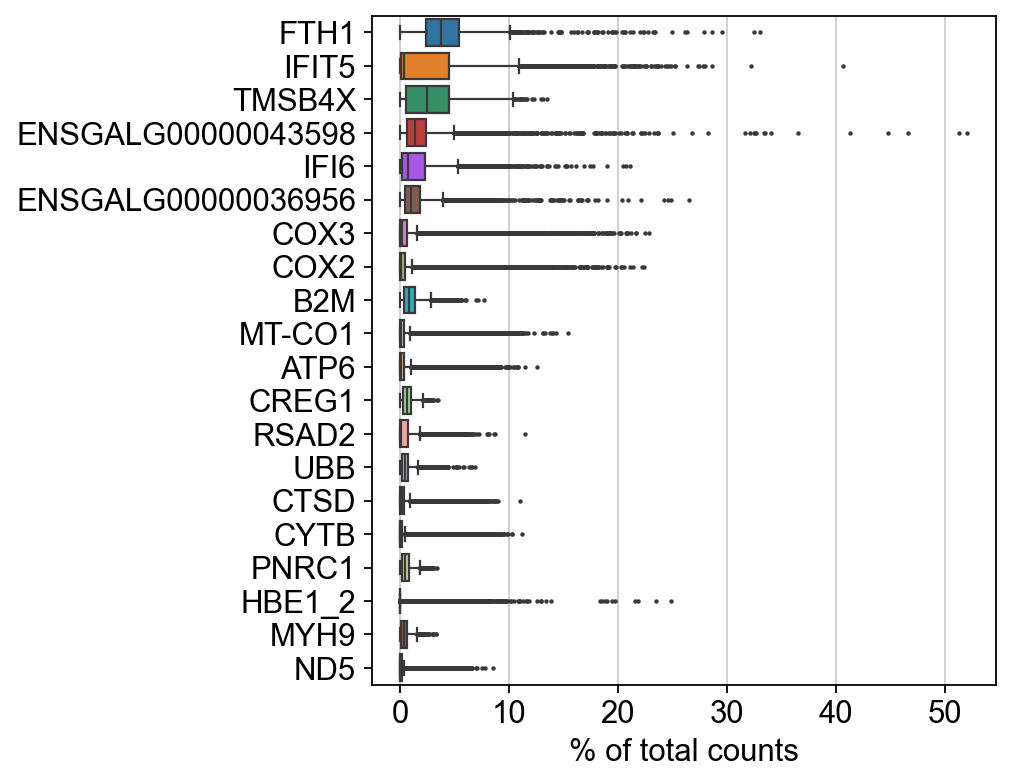

In [25]:
sc.pl.highest_expr_genes(adata_all_treatments, n_top=20)

In [26]:
sc.pp.filter_cells(adata_all_treatments, min_genes=100) 
sc.pp.filter_genes(adata_all_treatments, min_cells=3)
print(adata_all_treatments.shape)

filtered out 93 cells that have less than 100 genes expressed
filtered out 11273 genes that are detected in less than 3 cells
(6336, 13083)


In [27]:
dict_replace = {'COX1':'MT-COX1','COX2':'MT-COX2','COX3':'MT-COX3','ND1':'MT-ND1-1','ND1':'MT-ND1-2','ND2':'MT-ND2',
                'ND3':'MT-ND3','ND4':'MT-ND4','ND5':'MT-ND5','ND6':'MT-ND6','ND4L-1':'MT-ND4L','ATP6':'MT-ATP6','ATP8':'MT-ATP8',
                'CYTB':'MT-CYTB'}
adata_all_treatments.var.rename(dict_replace, inplace=True)

In [ ]:
adata_all_treatments.var['MT'] = adata_all_treatments.var_names.str.startswith('MT-')  # annotate the group of mitochondrial genes as 'MT'
sc.pp.calculate_qc_metrics(adata_all_treatments, qc_vars=['MT'], percent_top=None, log1p=False, inplace=True)

In [28]:
sc.pp.calculate_qc_metrics(adata_all_treatments, percent_top=None, log1p=False, inplace=True)

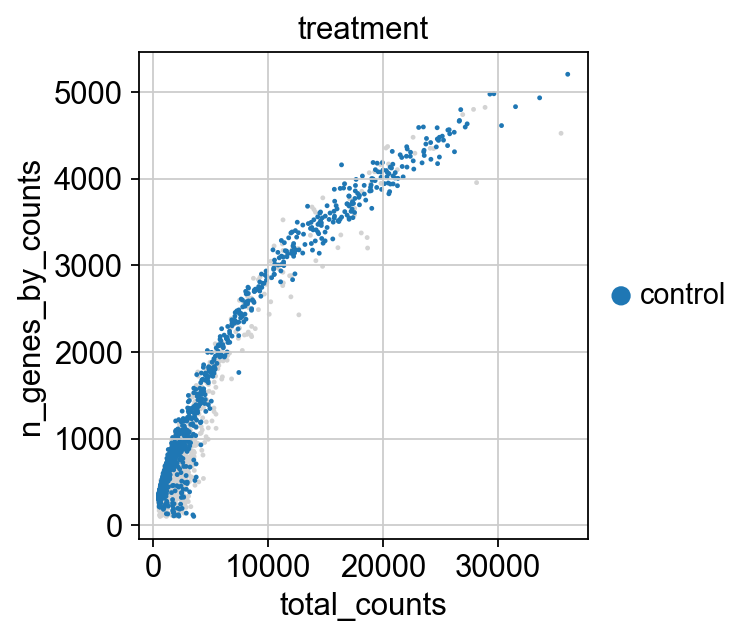

ValueError: `x`, `y`, and potential `color` inputs must all come from either `.obs` or `.var`

In [29]:
sc.pl.scatter(adata_all_treatments, x='total_counts', y='n_genes_by_counts', color='treatment')
sc.pl.scatter(adata_all_treatments, x='total_counts', y='pct_counts_MT', color='treatment')
sc.pl.scatter(adata_all_treatments, x='total_counts', y='n_genes', color='treatment', save=True)

In [ ]:
adata_all_treatments = adata_all_treatments[adata_all_treatments.obs.pct_counts_MT < 20] 
adata_all_treatments = adata_all_treatments[adata_all_treatments.obs.total_counts < 5000, :] # If filtering outliers (<0.1% of cells)

In [ ]:
import scrublet as scr

def scrub(adatas, adata_all_treatments, adata_all_treatments_names):  # based on raw individual samples. 
    print('Before scrublet: ', adata.shape[0])
    doub_index = []
    barcodes = []
    for data,name in zip(adatas, adata_all_treatments_names):
        data.raw = data
        sc.pp.normalize_total(data, target_sum=1e4)
        sc.pp.log1p(data)
        scrub = scr.Scrublet(data.raw.X)
        data.obs['doublet_scores'], data.obs['predicted_doublets'] = scrub.scrub_doublets()
        scrub.plot_histogram()
        print('Doublets' + name + ' :', data.obs[data.obs['doublet_scores'] > 0.25].shape[0])
        barcodes = data.obs[data.obs['doublet_scores'] < 0.25].index.to_list()
        for barcode in barcodes:
            doub_index.append(barcode + '-' + name)

    adata_all_treatments = adata_all_treatments[adata_all_treatments.obs.index.isin(doub_index)]
    print('After scrublet: ', adata_all_treatments.shape[0])
    return adata_all_treatments

In [ ]:
adata_all_treatments = scrub(adatas, adata_all_treatments, data_names)

In [ ]:
cell_cycle_genes = [x.strip() for x in open(r'/Code/data/single_cell/animals/regev_lab_cell_cycle_genes.txt')]

s_genes = cell_cycle_genes[:43]
g2m_genes = cell_cycle_genes[43:]
cell_cycle_genes = [x for x in cell_cycle_genes if x in adata.var_names]
s_genes = [x for x in s_genes if x in adata.var_names]
g2m_genes = [x for x in g2m_genes if x in adata.var_names]

In [ ]:
adata_all_treatments.var_names

In [ ]:
g2m_genes

In [ ]:
matching_values = adata_all_treatments.var_names.isin(cell_cycle_genes)

matching_values

In [ ]:
cell_cycle_adata = adata_all_treatments.copy()

sc.pp.normalize_per_cell(cell_cycle_adata, counts_per_cell_after=1e4)
sc.pp.log1p(cell_cycle_adata)
sc.pp.scale(cell_cycle_adata)
sc.tl.score_genes_cell_cycle(cell_cycle_adata, s_genes=s_genes, g2m_genes=g2m_genes)
adata_cc_genes = cell_cycle_adata[:, cell_cycle_genes].copy()
sc.tl.pca(adata_cc_genes)
sc.pl.pca_scatter(adata_cc_genes, color='phase', save=True)
adata_all_treatments.obs['S_score'] = cell_cycle_adata.obs['S_score'].copy()
adata_all_treatments.obs['G2M_score'] = cell_cycle_adata.obs['G2M_score'].copy()
adata_all_treatments.obs['phase'] = cell_cycle_adata.obs['phase'].copy()

In [ ]:
adata

In [ ]:
adata.var

In [ ]:
# adata.write(r'/Code/data/single_cell/animals/frog/frog_2/laevis/''frog_2_after_qc.h5ad')